# Keras를 활용한 Tensorflow 모델 만들기

케라시는 모든 종류의 신경망을 손쉽게 만들고 훈련, 평가, 실행할 수 잇는 고수진 딥러닝 API입니다.

쉽게 설명하자면 여러 복잡한 연산을 라이브러리내에 모두 구현을 하고 사용자가 모델의 구성만 신경 쓰게 해주는 좋은 라이브러리라고 생각하시면 됩니다.

원래는 Keras는 텐서플로우, CNTK, 시애노등을 계산 백엔드로 설정하고 사용할 수 있는데 텐서플로우가 버전 2로 업그레이드 되면서 케라스를 공식 고수준 API로 채택했고 이를 단순화하고 정리했습니다.


## 데이터 셋 준비

추후에 다음에 한번 더 다룰 것이지만 참고 사항으로 알고계시면 좋을것 같습니다.


딥러닝 라이브러리 말고 다른 ML을 위한 라이브러리인 사이킷런이 존재합니다.

사이킷런은 선형회귀 부터 시작해 clustering, svm. random forest, gradient boosting, k-means, DBSCAN등의 알고리즘에 대해 지원하는 라이브러리입니다.

이번에는 단순히 데이터셋을 받아오고 정규화 시키는데에만 사용하겠습니다.

또한 이번 데이터셋은 크기가 크지 않고 단순하기 때문에 원할한 이해를 위해 데이터로더를 사용하지 않겠습니다.

In [109]:
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence

In [3]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
dataset = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(dataset.data, dataset.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

데이터 셋 설명

In [5]:
dataset.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [6]:
print("Train dataset 크기 : ", np.shape(X_train_full))
print("Test dataset 크기 :", np.shape(X_test))

Train dataset 크기 :  (15480, 8)
Test dataset 크기 : (5160, 8)


dataset.feature_names에서 볼 수 있듯이 feature마다 단위가 다릅니다. 따라서 우리는 특정 단위에 따라 값의 중요성이 부여되는 것을 원치 않기 때문에 정규화를 진행해야합니다.

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # fit transform은 데이터 feature마다의 평균과 편차를 구해서 정규화를 진행하는 함수입니다.
X_valid = scaler.transform(X_valid) # transform은 위에서 구했던 평균과 편차를 그대로 가져와 데이터를 정규화 하는 것입니다.
X_test = scaler.transform(X_test)

케라스는 다음의 3가지 방식으로 모델을 만들 수 있다.

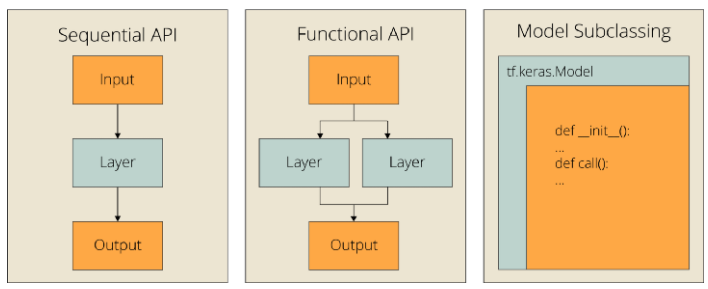

출처 : https://wikidocs.net/106897

# 1. Sequential API로 만들어보는 회귀 모델

Sequential API는 층을 순차적으로 쌓아서 모델을 만들어주는 API입니다.

In [111]:
# 모델 만들기
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation = "relu", input_shape = X_train.shape[1:]),
    tf.keras.layers.Dense(1)
])

다음은 tensorflow로 쌓은 모델에 대한 설명을 보여주는 함수입니다.

저희가 만든 모델 객체에 .summary를 해서 호출할 수 있습니다.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


저희가 만든 모델에 대한 설명은 다음과 같습니다.

1. 인풋이 들어오면 이를 Unit이 30개인 레이어에 넘겨줍니다.
 - 이때 사용한 activation 함수는 relu입니다.
 - inputshape를 정의하는 방법은 2가지 정도입니다. 
    1. tf.keras.layers.Input를 통해 Input을 위한 layer를 만드는 겁니다.
    2. 두번째는 위의 예시처럼 Input 다음에 오는 첫번째 레이어에 Input shape를 지정하는 겁니다.

    사실 Input shape없어도 돌아가긴합니다만 남들이 읽기 쉽고 유지보수를 쉽게 하고 여러 실험을 진행하기 위해서는 이러한 사소한 부분을 챙겨서 가는 습관을 가지는게 좋습니다.

2. 이후 이를 마지막 레이어에 넘기게 됩니다. 위의 데이터셋은 회귀문제이기 때문에 예측해야하는 값이 가격 하나라 unit이 1개인 layer에 넘겨주게 된겁니다.

사실 위의 summary말고 더 예쁜 시각화 방법이 있습니다. 

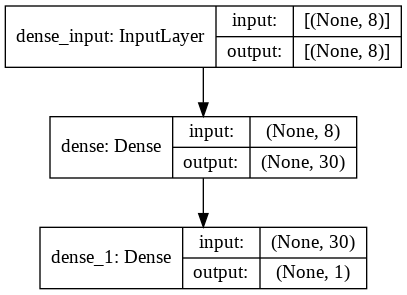

In [10]:
tf.keras.utils.plot_model(model, "test_model.png", show_shapes = True)

## 모델 compile시키고 학습 시키기

여기서 우리가 compile이라고 이야기 하는거는 우리가 어떤 손실함수를 사용할 것이고 어떤 optimizer를 사용할 것인지를 알려주는 부분입니다.

In [11]:
model.compile(loss = "mean_squared_error", optimizer = "Adam")

이제 우리는 학습을 진행 시킬겁니다. pytorch는 우리가 학습 프로세스를 정의해줬어야했지만 Keras는 fit함수로 처리를 해버립니다.

In [12]:
history = model.fit(x = X_train, y = y_train, epochs = 20, validation_data = (X_valid, y_valid))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.3171 - val_loss: 1.0741
Epoch 2/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5373 - val_loss: 0.7274
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4401 - val_loss: 1.4062
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4034 - val_loss: 0.7105
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3882 - val_loss: 0.7935
Epoch 6/20
363/363 [==============================] - 1s 1ms/step - loss: 0.3802 - val_loss: 1.0566
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3731 - val_loss: 0.6273
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3689 - val_loss: 1.8935
Epoch 9/20
363/363 [==============================] - 1s 1ms/step - loss: 0.3655 - val_loss: 0.3907
Epoch 10/20
363/363 [==============================] - 1s 1ms/step - loss: 0.3608 - val_loss: 0.3703

fit함수가 반환하는 History 객체에는 훈련 파라미터, 수행된 에포크 리스트가 포함됩니다.

사실 이것 말고 우리가 해당 객체를 쓰는 주요한 이유는 에포크가 끝날때마다 훈련세트와 검증 세트에 대한 손실과 측정한 지표를 담은 딕셔너리를 객체에 저장해준다는 겁니다.

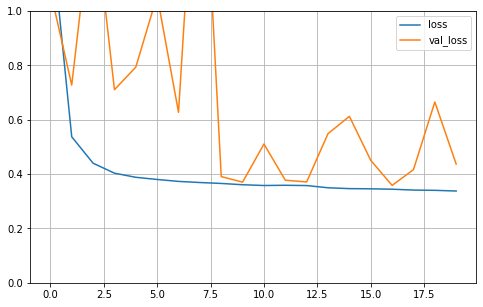

In [13]:
import pandas as pd
import matplotlib.pyplot as plt # 이 부분은 나중에 시각화 관련해서 따로 자료를 만들겠습니다.

pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## 모델 평가하기

Keras는 fancy한 기능을 하나 더 제공하는데요. evaluate입니다. 우리가 굳이 test를 위한 코드를 따로 만들 필요가 없습니다.

In [14]:
mse_test = model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 842us/step - loss: 0.3474


# Quiz 1


다음과 같은 모델을 만들어 보고 Parameter 갯수가 왜 저렇게 되는지 설명해보세요.

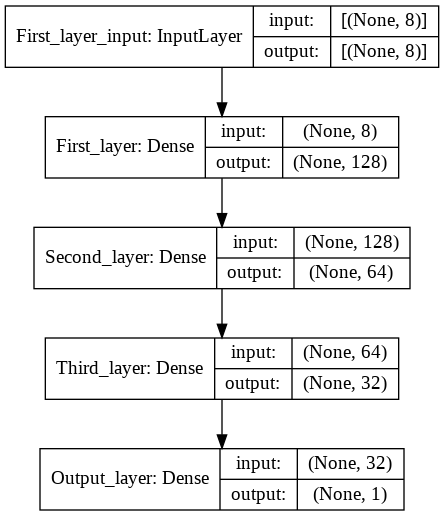

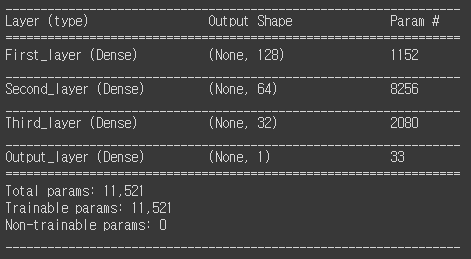

In [15]:
model = tf.keras.models.Sequential([
    '''
    code
    '''
])

# 함수형 API를 사용해 복잡한 모델 만들기

만약 우리가 다음과 같은 모델을 만들고자 할때 Sequential로는 만들지 못합니다. 이런 경우이 좀 더 유연하게 모델을 만들기 위해서 사용하는게 함수형 API입니다.

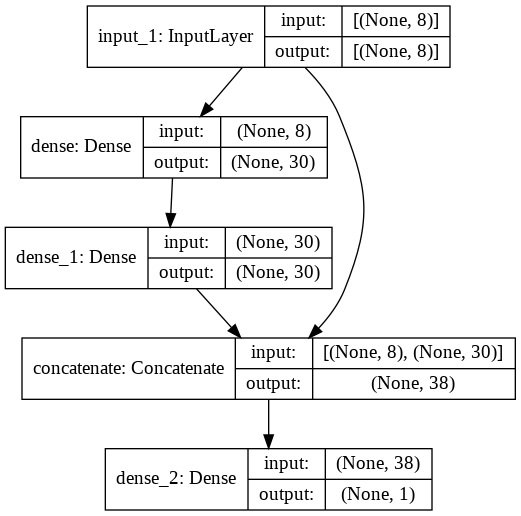

In [16]:
def build_model():
    input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
    hidden1 = tf.keras.layers.Dense(30, activation="relu")(input_)
    hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
    concat = tf.keras.layers.concatenate([input_, hidden2])
    output = tf.keras.layers.Dense(1)(concat)
    model = tf.keras.models.Model(inputs=[input_], outputs=[output])
    return model

이건 개인 코딩 취향인거 같은데 저는 개인적으로 함수형 API를 사용할때는 저렇게 build model을 해서 model을 반환 시키는 함수를 사용해서 주로 사용합니다.

위의 함수에서 가장 특이한 부분은 아마 concatenate 부분일겁니다. 먼저 concatentate는 두개의 레이어를 합쳐준다고 생각하시면 될것 같습니다. 다만 어떤 axis를 기준으로 합칠 것인가에 대해 궁금할것입니다.

이를 위해서는 함수의 default 입력변수를 살펴볼 필요가 있습니다.

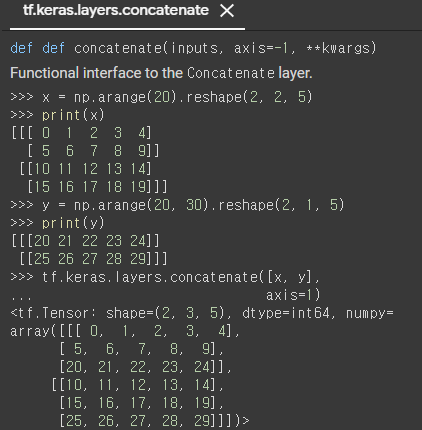

기본적인 함수 정의에서도 볼 수 있듯이 가장 마지막 axis를 기준으로 concatenate를 시켜줍니다.

## 딥러닝 모델에서 차원의 저주

이건 제가 명명한건데요. 차원의 저주는 원래 차원이 높아짐에 따라 여러 이유때문에 모델의 성능이 떨어지는 것을 의미하지만 제가 느끼는 차원의 저주는 딥러닝 모델을 customize할 때 옵니다.

텐서를 사실 이제까지는 한번 넣고 모델이 output을 뱉으면 끝이지만 추후에는 해당 텐서에 여러 다른 과정을 거치게 합니다. 그리고 다시 모델에 넣는 경우도 있죠. 이렇게 되는 과정에서 레이어들의 차원등을 무시하고 reduce_sum이나 행렬 곱을 진행하면서 어떻게 모양이 바뀌는지 생각을 안하면서 코딩을 하고 나면 디버깅 하는데 정말 많은 시간이 소요됩니다.(저는 이거 생각 안하고 코딩하다가 3일을 날려먹은적이 있습니다.) 그렇기 때문에 위의 concatenate 처럼 사실 생각해보면 아무것도 아닌 함수이지만 axis등을 한번 짚고 넘어가는 습관을 가지시면 저처럼 3일 버리는 코딩 같은거는 안 하실 수 있습니다.

In [18]:
functional_api_model = build_model()

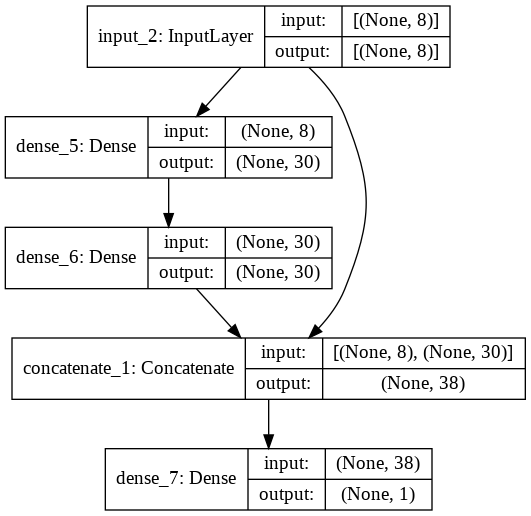

In [19]:
tf.keras.utils.plot_model(functional_api_model, "test_model.png", show_shapes = True)

#Quiz 2 

함수형 API를 사용해서 다음과 같은 모델을 만들어보세요.

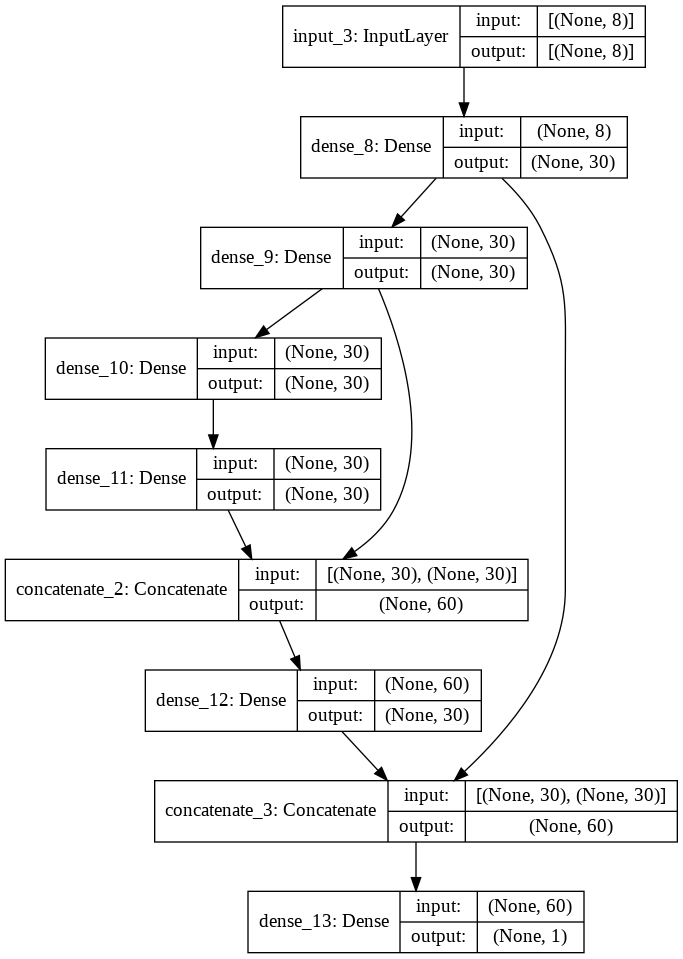

In [20]:
def build_model():
    '''
    code 
    '''
    return model

In [21]:
quiz_model = build_model()
tf.keras.utils.plot_model(quiz_model, "test_model.png", show_shapes = True)

# 서브클래싱 API

이제까지 우리는 시퀀셜 API, 함수형 API를 사용해서 모델을 만들어봤습니다. 이들은 선언적이고 정적입니다. 정적인 모델을 사실 젤 많이 쓰긴 하지만 가끔은 모델 내에 조건문이나 반복문 등과 같은 추가적인 계산 과정이 필요할 수 있습니다. 이럴때 사용하는게 서브클래싱 API입니다. 사실 이건 pytorch랑 생김새가 매우 비슷합니다.

In [107]:
class WideAndDeepModel(tf.keras.models.Model):
    #여기서 kwargs는 의미가 없긴하다
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

## **args* vs **kwargs

저희가 파이썬으로 코딩을 하다보면 저런 단어를 많이 보게 됩니다. *같은 경우 C언어에서 주고 값을 의미하지만 파이썬에서는 그렇지 않습니다.

1. *args
    
    이 지시어는 여러개의 인자를 함수의 인자로 받고자 할때 사용 됩니다. 이때 굳이 *args로 안 써도 됩니다. *a, *b 등으로 사용할 수도 있습니다만 코드의 가독성을 위해서는 *args로 쓰길 권장드립니다.

In [98]:
def multi_input_function(*args):
    for argument in args:
        print(argument)

In [102]:
multi_input_function(1)
print("=" * 10)
multi_input_function(1,2)
print("=" * 10)
multi_input_function(1,2, 3,4)
print("=" * 10)

1
1
2
1
2
3
4


2. **kwargs

kwargs는 함수의 인자는 (키워드 = 특정 값)으로 받게 된다. 즉, 인수를 딕셔너리 형태로 받는다는 뜻이다. 밑의 예시를 보자

In [104]:
def dict_input_function(**kwargs):
    for key, value in kwargs.items():
        print("Key" , key)
        print("Value", value)
        print("=" * 10)

In [105]:
dict_input_function(MyName = "Jinhwan", Hello = "World")

Key MyName
Value Jinhwan
Key Hello
Value World


# 콜백 사용하기

Tensorflow에서 fit 함수가 받는 인자 중에 callback이라는 인자가 있습니다. 이는 훈련, 평가, 학습 등에 있어서 특정 동작을 할 수 있게 만들어 주는 인자 입니다.

In [110]:
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_test_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start testing; got log keys: {}".format(keys))

    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop testing; got log keys: {}".format(keys))

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start predicting; got log keys: {}".format(keys))

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop predicting; got log keys: {}".format(keys))

    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: start of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: end of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Predicting: start of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Predicting: end of batch {}; got log keys: {}".format(batch, keys))

In [112]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation = "relu", input_shape = X_train.shape[1:]),
    tf.keras.layers.Dense(1)
])

In [113]:
model.compile(loss = "mean_squared_error", optimizer = "Adam")

In [ ]:
history = model.fit(x = X_train, y = y_train, epochs = 20, validation_data = (X_valid, y_valid), callbacks= [CustomCallback()])

이렇게 학습 과정을 customize할 수 있습니다.

물론 매번 내가 원하는 callback을 만들어 쓸 수도 있지만 tensorflow에서 기본적으로 제공하는 callback이 존재합니다.

###Early Stopping
```
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
```

patience는 loss가 더이상 내려가지 않을때 3번의 에포크동안 기다려보겠다는 겁니다. 3번의 에보크 동안 loss가 내려가지 않으면 학습을 중단 시킵니다.

### LearningRateScheduler

```
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
       return 0.001 * tf.math.exp(0.1 * (10 - epoch))
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.fit(dataset, epochs=100, callbacks=[callback])  
```

다음과 같이 epoch를 인자로 받는 함수를 만들어서 callback에 넣어주면 에포크마다 learning rate를 우리가 정의한 방식대로 업데이트 할 수 있습니다.

### Model Check Point

```
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./model/checkpoint.{epoch:02d}.hdf5',
    save_weights_only=True,    
    save_freq='epoch')
```

save_freq에 정의 된 기준에 따라 모델을 filepath에 저장하는 방식입니다. h5파일만 저장 할 수 있지만 save_weigths_only를 True로 지정하면 모델의 파라미터 값을 저장 하게 됩니다.

#Quiz3

캘리포니아 데이터 셋을 사용해서 loss가 0.3이하로 떨어지면 학습을 종료시키는 callback을 만들어보세요. 또한 earlystopping과 LearningRateScheduler, ModelCheckPoint도 모델을 학습 시키는 Callback에 들어가야합니다.